# Potential coastal flood impacts

## Risk assessment methodology

Below we consider the potential impacts of coastal flooding caused by extreme water levels. The methodology of calculating the flood risk is similar to that of the river flooding workflow (link). The flood risk is calculated as a combination of flood maps and economic damage functions. The flood maps are considered for two scenarios (present and 2050 under RCP8.5 climate scenario), and for different return periods.

The following datasets are used as input for the calculations:

- Flood maps: the maps of flood depth and extent are available from ...PLANETARY COMPUTER (link). Maps for 2018 ("present") and 2050 are available, for extreme water level return periods of 2, 5, 10, 25, 50, 100 and 250 years. The 2050 scenario includes the effect of sea level rise as estimated under RCP8.5 (high-emission scenario). The flood maps have a resolution of 3 arcseconds (30-75 m in European geographical area, depending on latitude).
- Land-use information: The land cover map is available from the [Copernicus Land Monitoring Service](https://land.copernicus.eu/pan-european/corine-land-cover)   
- Flood damage: translated based on flood inundation depth using damage curves (available [here](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688). For each grid point, the inundation depth is used to assess the damage, based on the land use type and country-specific parameters that can be defined by the user.   


## Technical description of the considered flood map dataset and its limitations

(#TODO: to write up the description based on points below)

GTSM, ERA5
bathtub inundation modelling with attenuation correction over land
MERIT DEM, NASADEM
SLR from IPCC AR5
The effect of climate change is accounted for by superimposing sea level rise on the water level values (KNMI).

Coastal resolution of GTSM is high on global scale, but for local areas with complex bathymetry it may be too coarse (e.g. estuaries or semi-enclosed bays).
This dataset helps to understand the flood potential at a location. It does not include the protective effect of existing man-made coastal protections (e.g. dams, storm barriers). 
For a more accurate estimate of risks, it is recommended to perform local flood modelling, taking the results of global models as boundary conditions. Local models can take better account of complex bathymetry and topography, and incorporate local data and knowledge.

## Preparation work

### Load libraries
In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) A library for geospatial data processing.

# CHECK
- [planetary-computer](https://pypi.org/project/planetary-computer/) A library for interacting with the Microsoft Planetary Computer.
- [dask](https://www.dask.org/) A library for parallel computing and task scheduling.
- [pystac-client](https://pystac-client.readthedocs.io/en/stable/) A library for for working with STAC Catalogs and APIs.
- [shapely](https://shapely.readthedocs.io/en/stable/index.html) A library for manipulation and analysis of geometric objects.
- [regionmask](https://regionmask.readthedocs.io/en/stable/) A library for creating masks of geographical regions.

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data.

In [9]:
# Package for downloading data and managing files
import os
import pooch
import dask.distributed
import pystac_client
import planetary_computer

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import xarray as xr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx
import shapely.geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs


import regionmask # CHECK

### Create the directory structure

In [2]:
# Define the folder for the flood workflow
workflow_folder = 'coastal_flood_workflow'

# Check if the workflow folder exists, if not, create it along with subfolders for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(workflow_folder, 'data'))
    os.makedirs(os.path.join(workflow_folder, 'results'))

In [3]:
# Define directories for data and results within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, 'data')
results_dir = os.path.join(workflow_folder, 'results')

# Retrieve coastal flood dataset

In [4]:
# Define source directory for dataset (TODO: change to an online source once available)
floodmap_dir = r'C:\Users\aleksand\OneDrive - Stichting Deltares\Documents\Projects\CLIMAAX\Coastal_flooding\floodmaps_dataset'

# Define a list of return periods 
return_periods = [1,10,50,100,500,1000] # [1,2,5,10,25,50,100,250,500,1000]
years = [2020,2030,2050,2080]
rcps = ['rcp26','rcp45','rcp60','rcp85']
percs = [50,95]

# Define geographical area of interest

#bbox = [1.983871,41.252461,2.270614,41.449569] # Barcelona, Spain
#areaname = 'Barcelona'

bbox = [-2.94,51.4,-2.5,51.7] 
areaname = 'Bristol'

#bbox = [-1.6,46,-1.05,46.4] 
#areaname = 'La_Rochelle'

#bbox = [12.1,45.1,12.6,45.7] 
#areaname = 'Venice'

In [5]:
# load flood maps for different scenarios and years in one array, clipped to region of interest
for year in years:
    for rp in return_periods:
        for rcp in rcps:
            for perc in percs:
                if (perc==95) & (rcp != 'rcp85'):
                    continue
                
                # load dataset
                if year==2020:
                    ext = f'{year}_rp{rp:04}_slr0_nosub'
                    data_path = os.path.join(floodmap_dir,'01_current_climate',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')                 
                else:
                    ext = f'{year}_rp{rp:04}_slr_{rcp}_Perc{perc}_nosub'
                    data_path = os.path.join(floodmap_dir,'03_future_nosub',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')
                    
                if not os.path.isfile(data_path):
                    continue

                # open dataset for the given scenario, year and return period
                ds = xr.open_dataset(data_path,decode_coords="all").drop_vars(['time']).squeeze()['inun']

                # reproject to European projection coordinates
                ds.rio.write_crs("epsg:4326", inplace=True)
                ds1 = ds.rio.clip_box(minx=-16.1, miny=40.18, maxx=32.88, maxy=84.73, crs="EPSG:4326"); del ds # clip to Europe to reduce amount of data to be reprojected
                ds2 = ds1.rio.reproject("epsg:3035"); del ds1
                ds3 = ds2.rio.clip_box(*bbox, crs="EPSG:4326"); del ds2
                ds3 = ds3.where(ds3 > 0,np.nan)
                ds = ds3; del ds3
                
                # add coordinates to specify year, rp, scenario to prepare dataset for merging
                ds = ds.assign_coords(year=year); ds = ds.expand_dims('year')
                ds = ds.assign_coords(return_period=rp); ds = ds.expand_dims('return_period')
                ds = ds.assign_coords(scenario=rcp); ds = ds.expand_dims('scenario')
                ds = ds.assign_coords(slr_percentile=perc); ds = ds.expand_dims('slr_percentile')

                if (year==years[0]) & (rp==return_periods[0]) & (rcp==rcps[0]) & (perc==percs[0]):
                    floodmaps = ds
                else:
                    floodmaps = xr.merge([floodmaps,ds])
                del ds
                    

In [ ]:
# Define functions useful for plotting

def plot_extent(r, floodmap):
    e, s, w, n = r.polygon.bounds
    aspect = abs((w-e)/(n-s))
    fig = plt.figure(figsize=(8, 8/aspect))
    ax = prudence[[r.number]].plot(add_ocean=True, resolution='50m',projection=ccrs.PlateCarree(), add_label=False, 
                                              line_kws={'linewidth': 0.}) 
    ax.set_aspect('equal')
    grid = ax.gridlines(draw_labels=True)
    grid.top_labels = False
    grid.right_labels = False
    ax.add_feature(lakes, alpha=0.4)
    ax.add_feature(riv, alpha=0.4)
    ax.add_feature(borders, alpha=0.4)
    qm = floodmap.plot(ax=ax, vmin=0, vmax=3.0,add_colorbar = False,cmap='turbo')
    cbar = set_colorbar(ax, qm, label='Flood depth [m+MSL]')
    return fig, ax

def set_colorbar(ax, im, wspace=0.02, width=0.015, rel_height=0.5, label='', extend='neither', inset_bottom=True):
    # make colorbar
    fig = plt.gcf()
    cbar_ax = fig.add_axes([1, 1, 0.1, 0.1]) # new ax
    cbar = fig.colorbar(im, extend=extend, cax=cbar_ax)
    cbar.ax.set_ylabel(label, rotation='vertical')
    posn = ax.get_position()
    h = posn.height * rel_height
    y0 = posn.y0 + posn.height - h
    if inset_bottom:
        y0 = posn.y0
    cbar_ax.set_position([posn.x1 + wspace, y0, width, h])
    return cbar

wc = cfeature.COLORS['water']
riv = cfeature.NaturalEarthFeature(name='rivers_lake_centerlines', category='physical', scale='50m', 
                                   facecolor='none', edgecolor=wc, )
lakes = cfeature.NaturalEarthFeature(name='lakes', category='physical', scale='50m', 
                                   facecolor=wc, edgecolor=wc, )
borders = cfeature.NaturalEarthFeature(name='admin_0_countries', category='cultural', scale='50m', 
                                   facecolor='none')

In [ ]:
# TO BE REMOVED
# CHECKPLOTS for European regions
# Plot maps for all years and scenarios for different European regions

bbox = [-10.5,36,31,71.2] # Europe 

plot_dir = os.path.join(data_dir,'floodmap_plots_European_regions')
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

for year in years[1:]:
    for rp in return_periods:
        for rcp in rcps:
            for perc in percs:
                if (perc==95) & (rcp != 'rcp85'):
                    continue
                
                # load dataset
                ext = f'{year}_rp{rp:04}_slr_{rcp}_Perc{perc}_nosub'
                data_path = os.path.join(floodmap_dir,'03_future_nosub',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')
                floodmap = xr.open_dataset(data_path).drop_vars(['time']).squeeze()['inun']
                floodmap = floodmap.sel(lon=slice(bbox[0], bbox[2]), lat=slice(bbox[1], bbox[3])).load()
                floodmap = floodmap.where(floodmap > 0,np.nan)

                # plot dataset per region
                mask = prudence.mask_3D(floodmap.lon, floodmap.lat)
                
                for prudence_region in np.arange(1, 8, 1):
                    r= prudence.regions[prudence_region]
                    floodmap_region = floodmap.where(mask.sel(region=prudence_region),drop=True)
                    fig, ax = plot_extent(r, floodmap_region); del floodmap_region
                    title_sup = 'permanent inundation' if rp == 0 else 'Flood depth at 1/{:0.0f} years water level'.format(rp)
                    ax.set_title('Flood maps for extreme sea level rise scenarios \n' + title_sup + '\n' + r.name + ' region', size=14)
                    fn = os.path.join(plot_dir,'Floodmap_region_{}_{}_rp{:04d}_Perc{}.png'.format(r.name, rcp, rp, perc))
                    plt.savefig(fn, bbox_inches='tight', dpi=225)
                    plt.close()

#### Land-use information

In [ ]:
# Define the URL for the LUISA basemap and download it using Pooch
url = 'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/LUISA_basemap_020321_100m.tif'
pooch.retrieve(
    url=url,
    known_hash=None,  # Hash value is not provided
    path=data_dir,    # Save the file to the specified data directory
    fname='LUISA_basemap_020321_100m.tif'  # Save the file with a specific name
)

#### Damage curves

We will use damage curves files from the JRC.


Text(0, 0.5, 'Damage ratio [%]')

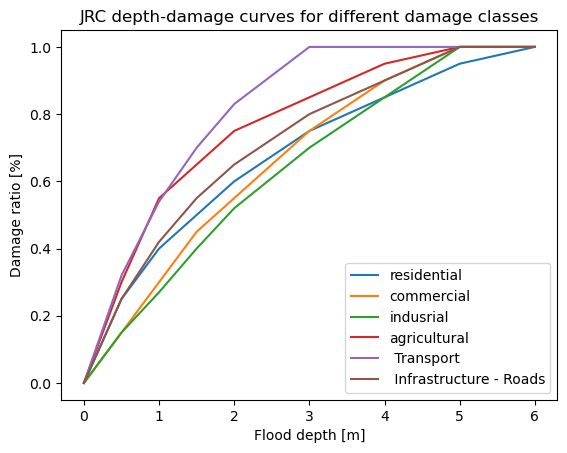

In [6]:
# Import damage curves of the JRC from a CSV file into a pandas DataFrame
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)

# Plot the JRC depth-damage curves
JRC_curves.plot()

# Set the title and labels for the plot
plt.title('JRC depth-damage curves for different damage classes')
plt.xlabel('Flood depth [m]')
plt.ylabel('Damage ratio [%]')

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Flood data

We have ...

The maps depict river flood depths (in meters) for six different flood frequencies (from 1-in-1-years to 1-in-1000-years). 

The maps can be used to assess multipe types of risk from coastal flooding in a region. Potential uses are the exposure of population, economic assets to river floods, flooded roads, assessing acces to healthcare facilities, etc. In this risk recipe we will look into economic damages.

Disclaimer about flood protection and infrastructure...
Disclaimer about maps being based on static "bathtub" method...

# TODO: do we want to save maps locally?
All the downloaded files are stored in our **data_dir** folder, with filenames starting with: **floodmap_EFAS_RP** folowed by the number of years for the return period.  

In [8]:
# Define the filename for the flood map based on the specified data directory
#filename_flood = f'{data_dir}/floodmap_EFAS_RP500_C.tif'

# Open the flood map raster using rioxarray
#flood = rxr.open_rasterio(filename_flood)

# Display the flood map dataset
floodmaps

<xarray.Dataset>
Dimensions:         (lat: 36, lon: 53, year: 4, return_period: 6, scenario: 4,
                     slr_percentile: 2)
Coordinates:
  * lat             (lat) float64 51.4 51.41 51.42 51.43 ... 51.68 51.69 51.7
  * lon             (lon) float64 -2.938 -2.929 -2.921 ... -2.521 -2.513 -2.504
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
Data variables:
    inun            (slr_percentile, scenario, return_period, year, lat, lon) float32 ...
Attributes:
    units:          m
    long_name:      Coastal flooding
    standard_name:  water_surface_height_above_reference_datum
    comment:        water_surface_reference_datum_altitude is given in file /...

In [ ]:
### Land use data
All the Land use data is extracted in the LUISA_LU directory inside our data_dir folder. Take a look a the files First we have the land use projections for 2010, 2020, 2030, 2040 and 2050. Using maps from the past, past events can be reconstructed. By using future maps, added or decreased risk due to changes in landuse can be found. We also have files labeled with **legend** that provide metadata and mapping between different land use classes.

Let's explore one of the land use projection files, for example 2030 projection (2030_LUISA_LU).  
We will use rioxarray to open the file and list its content.

In [7]:
# Define the filename for the land use map based on the specified data directory
filename_land_use = f'{data_dir}/LUISA_basemap_020321_100m.tif'

# Open the land use map raster using rioxarray
land_use = rxr.open_rasterio(filename_land_use)

# Display the opened land use map
land_use

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
[2990000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## Process the data

The flood and land use datasets have different resolutions. Flood extent maps are at a coarser resolution of 300 to 750 m (depending on latitude), while land use data is at 50 m resolution. We can use xarray to get them to the same resolution.  

But first we need to clip the land use dataset to the same area as the flood dataset that was loaded.

Text(0.5, 1.0, 'LUISA Land Cover for the defined area')

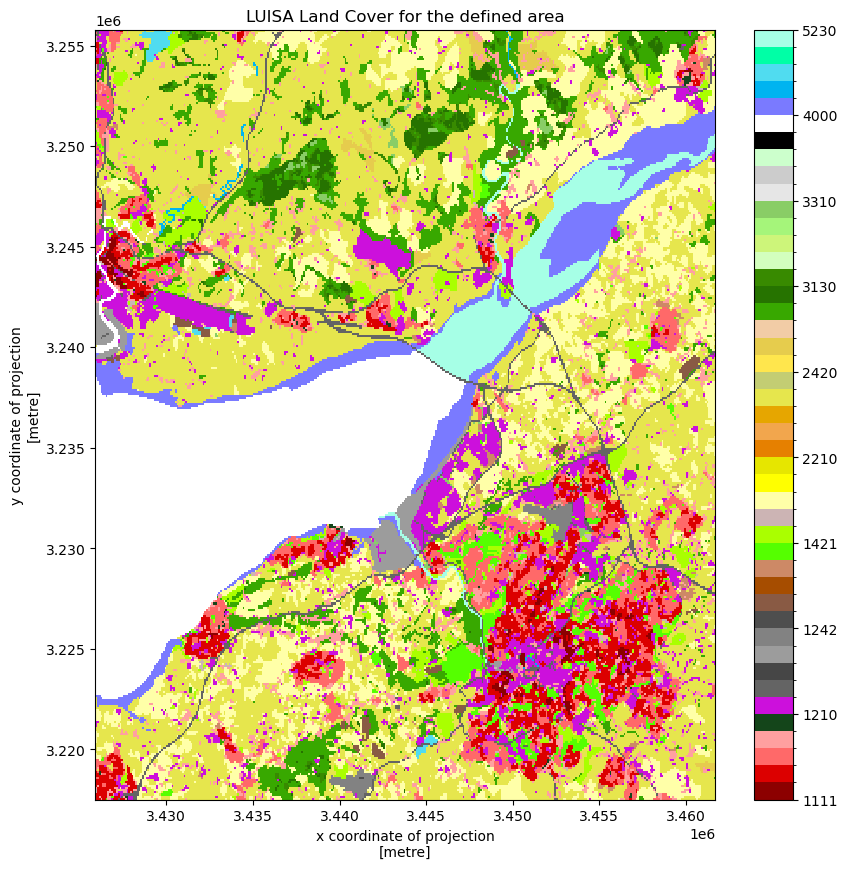

In [8]:
# Set the coordinate reference system (CRS) for the land use map to EPSG:3035
land_use.rio.write_crs(3035, inplace=True)

# Clip the land use map to the specified bounding box and CRS
land_use_small_area = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

# Define values and colors for different land use classes
LUISA_values = [1111, 1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]

# Plot the land use map using custom levels and colors
land_use_small_area.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10, 10))

# Set the title for the plot
plt.title('LUISA Land Cover for the defined area')


In [45]:
# Make plots of floodmaps loaded for the area of interest
plot_dir = os.path.join(data_dir,'floodmap_plots')
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

# Define maximum range of inundation depth for plotting purposes
vrange=[0,round(np.nanmax(floodmaps['inun'].sel(year=2080,scenario='rcp85',slr_percentile=95).isel(return_period=5).values))]

# function to plot a panel of plots corresponding to storms with different return periods
def plot_floodmap_scenarios(ds,year,scenario,slr_perc,vrange):
    fig,axs = plt.subplots(figsize=(15, 8),nrows=2,ncols=3,sharex=True,sharey=True,layout='constrained')
    for pp in range(0,6):
        bs=ds['inun'].sel(year=year,scenario=scenario,slr_percentile=slr_perc).isel(return_period=pp).plot(ax=axs[pp//3,pp%3],vmin=vrange[0],vmax=vrange[1],add_colorbar=False,cmap='turbo',alpha=0.5)
        ctx.add_basemap(axs[pp//3,pp%3],crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
        axs[pp//3,pp%3].set_title(f'1 in {ds.return_period.values[pp]} return period',fontsize=12)
        axs[pp//3,pp%3].xaxis.label.set_visible(False)
        axs[pp//3,pp%3].yaxis.label.set_visible(False)
    
    axs[0,0].yaxis.label.set_visible(True); axs[1,0].yaxis.label.set_visible(True); 
    axs[1,0].xaxis.label.set_visible(True); axs[1,1].xaxis.label.set_visible(True); axs[1,2].xaxis.label.set_visible(True)
    fig.colorbar(bs,ax=axs[:],orientation="vertical",pad=0.01,shrink=0.9,aspect=30).set_label(label=f'Coastal flood inundation height [m]',size=14)  
    plt.suptitle('Flood maps for extreme sea level rise scenarios \n' + f'Scenario {scenario.upper()}, year {year}',fontsize=12)
    return fig


In [ ]:
# save plots for all scenarios
for year in years:
    for scenario in rcps:
        for slr_perc in percs:
            if (perc==95) & (scenario != 'rcp85'):
                continue
            fileout = os.path.join(plot_dir,'Floodmap_area_{}_{}_rpAll_Perc{}.png'.format(areaname, scenario, slr_perc))
            fig = plot_floodmap_scenarios(floodmaps,year,scenario,slr_perc,vrange)
            fig.savefig(fileout) 
            plt.close()

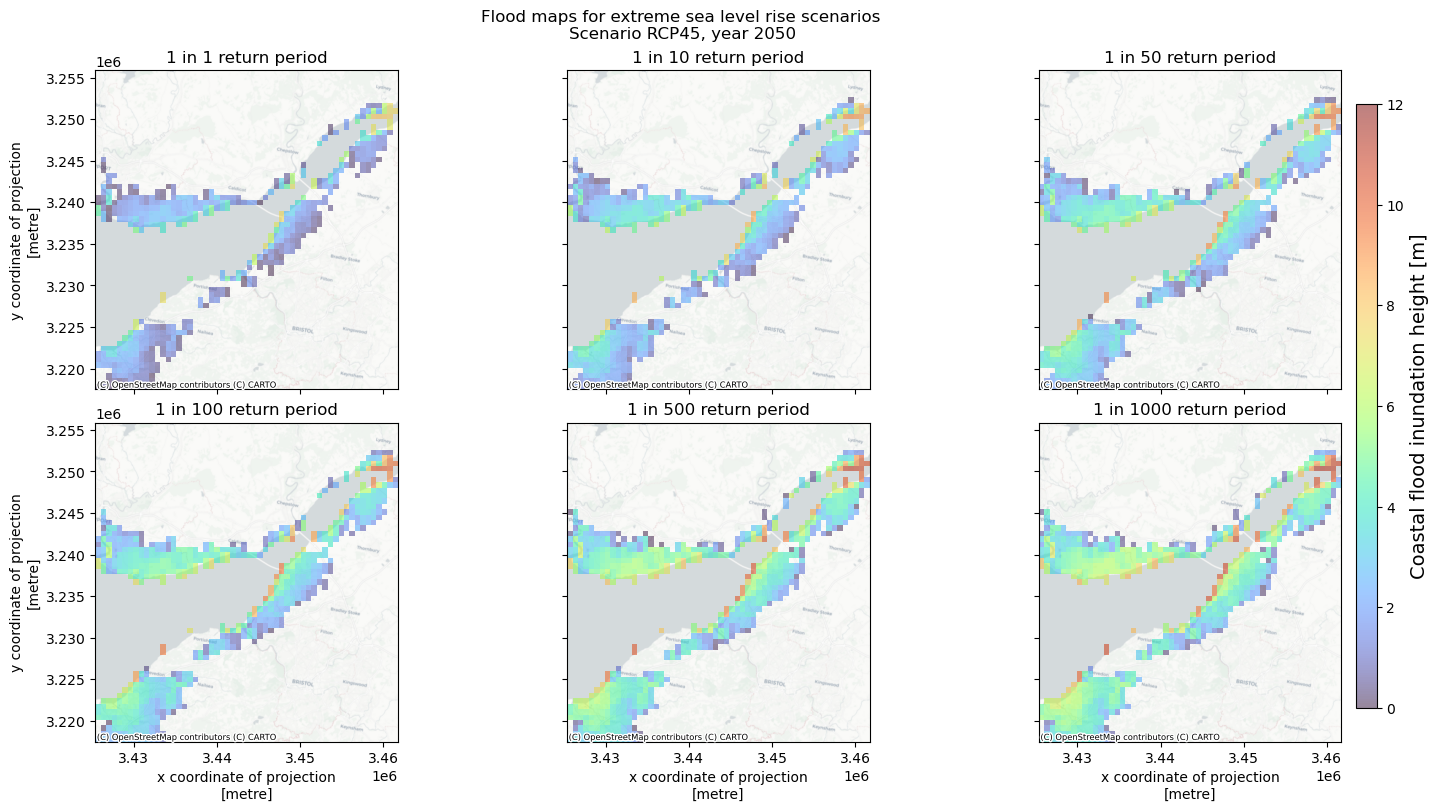

In [172]:
# show an example plot
fig=plot_floodmap_scenarios(floodmaps,2050,'rcp45',50,vrange)

#### Interpolate the land use data array

Next we need to interpolate the flood data into the land use map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

In case our land use map was courses we would not like to actually interpolate the land use values between gridcells because then 'new' land use values will be created that do not have a meaning. To prevent that we are using method **'nearest'**, to assign the values to the nearest grid points.

In [36]:
floodmaps

<xarray.Dataset>
Dimensions:         (x: 56, y: 59, year: 4, return_period: 6, scenario: 4,
                     slr_percentile: 2)
Coordinates:
  * x               (x) float64 3.426e+06 3.426e+06 ... 3.461e+06 3.461e+06
  * y               (y) float64 3.256e+06 3.255e+06 ... 3.218e+06 3.218e+06
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
Data variables:
    inun            (slr_percentile, scenario, return_period, year, y, x) float32 ...
Attributes:
    units:          m
    long_name:      Coastal flooding
    standard_name:  water_surface_height_above_reference_datum
    comment:        water_surface_reference_datum_altitude is given in file /...

In [35]:
# Reproject the clipped flood map to match the resolution and extent of the land use map
for year in years:
    for scenario in rcps:
        for slr_perc in percs:
            if (slr_perc==95) & (scenario != 'rcp85'):
                continue
            for pp in range(0,6):
                ori_map = floodmaps['inun'].sel(year=year,scenario=scenario,slr_percentile=slr_perc).isel(return_period=pp)
                new_map = ori_map.rio.reproject_match(land_use_small_area, resampling=Resampling.bilinear); del ori_map
                ds = new_map.to_dataset(); del new_map
                ds = ds.expand_dims(dim={'scenario':1,'year':1,'return_period':1,'slr_percentile':1})

                if (year==years[0]) & (pp==0) & (scenario==rcps[0]) & (slr_perc==percs[0]):
                    floodmaps_resampled = ds
                else:
                    floodmaps_resampled = floodmaps_resampled.merge(ds)


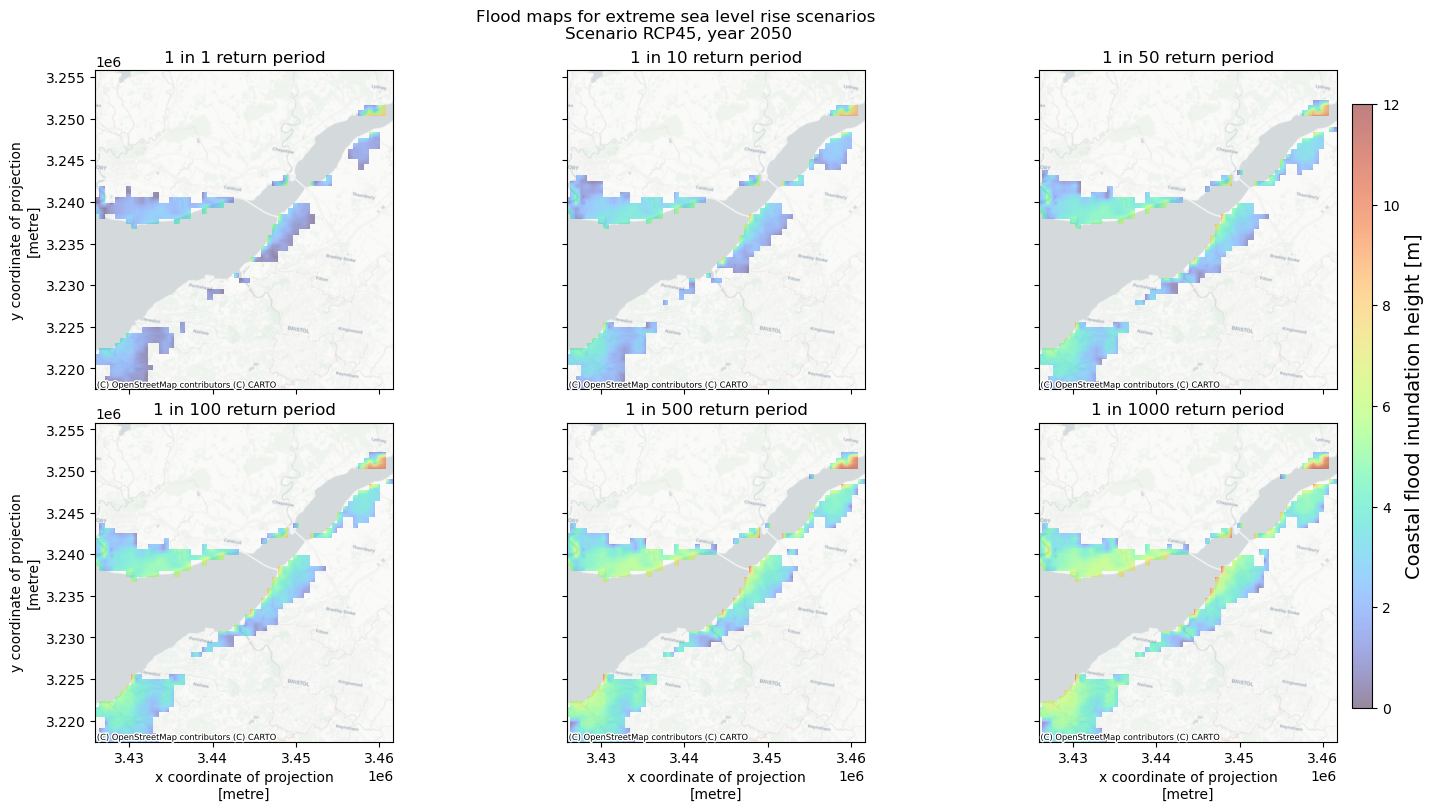

In [46]:
# make checkplot
fig=plot_floodmap_scenarios(floodmaps_resampled,2050,'rcp45',50,vrange)

In [47]:
# check the new resolution of the floodmap
floodmaps_resampled.rio.resolution()

(100.0, -100.0)

For now we save them as tif so DamageScanner package can use them as input.

In [48]:
# Create GeoTIFF files for the resampled flood maps
tif_dir = os.path.join(data_dir,'floodmap_plots_resampled_tif')
if not os.path.isdir(tif_dir): os.makedirs(tif_dir)

In [49]:
floodmaps_resampled = floodmaps_resampled.sortby(["y"],ascending=False) 

In [50]:
floodmaps_resampled

<xarray.Dataset>
Dimensions:         (x: 358, y: 383, slr_percentile: 2, year: 4, scenario: 4,
                     return_period: 6)
Coordinates:
  * x               (x) float64 3.426e+06 3.426e+06 ... 3.462e+06 3.462e+06
  * y               (y) float64 3.256e+06 3.256e+06 ... 3.218e+06 3.218e+06
  * slr_percentile  (slr_percentile) int32 50 95
  * year            (year) int32 2020 2030 2050 2080
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * return_period   (return_period) int32 1 10 50 100 500 1000
    spatial_ref     int32 0
Data variables:
    inun            (scenario, year, return_period, slr_percentile, y, x) float32 ...

In [51]:
for year in years:
    for scenario in rcps:
        for slr_perc in percs:
            if (slr_perc==95) & (scenario != 'rcp85'):
                continue
            for pp in range(0,6):
                data_tif = floodmaps_resampled['inun'].sel(year=year,scenario=scenario,slr_percentile=slr_perc,drop=True).isel(return_period=pp,drop=True)
                with rasterio.open(
                    f'{tif_dir}/floodmap_resampled_{areaname}_{year}_rp{floodmaps_resampled.return_period.values[pp]:04d}_{scenario}_Perc{slr_perc}.tif',  
                    'w',
                    driver='GTiff',
                    height=data_tif.shape[0],
                    width=data_tif.shape[1],
                    count=1,                    
                    dtype=str(data_tif.dtype),
                    crs=data_tif.rio.crs,
                    transform=data_tif.rio.transform(),
                ) as dst:
                    # Write the data array values to the rasterio dataset
                    dst.write(data_tif.values,indexes=1)


In [232]:
# Create a new GeoTIFF file for the clipped land use map
with rasterio.open(
    f'{data_dir}/land_use_small_area.tif',
    'w',
    driver='GTiff',
    height=land_use_small_area.shape[1],
    width=land_use_small_area.shape[2],
    count=1,
    dtype=str(land_use_small_area.dtype),
    crs=land_use_small_area.rio.crs,
    transform=land_use_small_area.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_small_area.values)


### Additional info for the LUISA land use maps

In order to assess the damage done by the flood we also need to assign a monetary value to the land use categories. We define this as the potential loss in €/m². Go into the provided **LUISA_damage_info_curves.xlsx** and tweak the information to your own region.

In [56]:
# Read damage curve information from an Excel file into a pandas DataFrame
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)

# Extract the 'total €/m²' column to get the maximum damage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])

# Save the maximum damage values to a CSV file
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')

# Display the first 10 rows of the resulting DataFrame
maxdam.head(10)


,total €/m²
Land use code,
1111,600.269784
1121,414.499401
1122,245.022999
1123,69.919184
1130,0.000000
1210,405.238393
1221,40.417363
1222,565.843080
1230,242.504177


Text(0.5, 0, 'Inundation depth (m)')

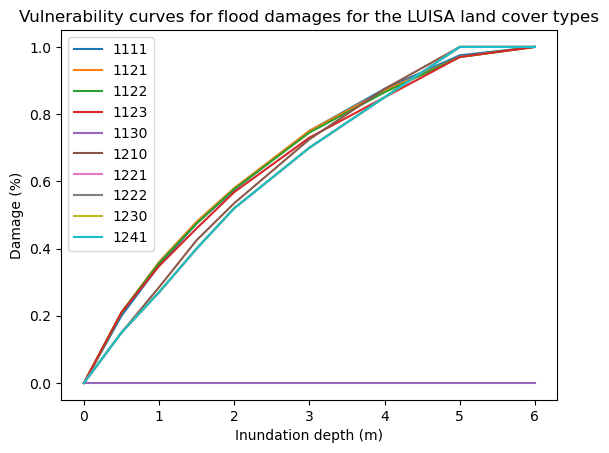

In [57]:
# Create a new DataFrame for damage_curves_luisa by copying JRC_curves
damage_curves_luisa = JRC_curves.copy()

# Drop all columns in the new DataFrame
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

# Define building types for consideration
building_types = ['residential', 'commercial', 'industrial']

# For each land use class in maxdamage, create a new damage curve
for landuse in maxdam.index:
    # Find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # Create a new curve based on the ratios and JRC_curves
    damage_curves_luisa[landuse] = ratio[0] * JRC_curves.iloc[:, 0] + \
                                   ratio[1] * JRC_curves.iloc[:, 1] + \
                                   ratio[2] * JRC_curves.iloc[:, 2]

# Save the resulting damage curves to a CSV file
damage_curves_luisa.to_csv(f'{data_dir}/curves.csv')    

# Plot the vulnerability curves for the first 10 land cover types
damage_curves_luisa.iloc[:, 0:10].plot()
plt.title('Vulnerability curves for flood damages for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Inundation depth (m)')


## Calculate the damage using DamageScanner library

Now that we have all pieces of the puzzle in place, we can start doing the risk calculation. For this we are using the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/index.html) python library which allows for an easy damage calculation. 

The DamageScanner takes the following data:
- The clipped and resampled flood map 
- The clipped landuse map
- The created vulnerability curves 
- A table of maximum damages per landuse category 

In [115]:
# Select scenario
year = 2080
rcp = 'rcp85'
slr_perc = 95
rp = 100

In [116]:
# Define file paths for the flood map, land use map, vulnerability curves, and maximum damages
inun_map = os.path.join(tif_dir, f'floodmap_resampled_Bristol_{year}_rp{rp:04}_{rcp}_Perc{slr_perc}.tif')
landuse_map = os.path.join(data_dir, 'land_use_small_area.tif')
curve_path = os.path.join(data_dir, 'curves.csv')
maxdam_path = os.path.join(data_dir, 'maxdam_luisa.csv')


In [117]:
# Do the damage calculation and save the results as 'flood_scenario'
loss_df = RasterScanner(landuse_map,
                        inun_map,
                        curve_path,
                        maxdam_path, 
                        save = True, 
                        nan_value = None, 
                        scenario_name= '{}/flood_scenario_{}_{}_Perc{}_{}_rp{:04}'.format(results_dir,areaname, scenario, slr_perc,year,rp),
                        dtype = np.int64)

In [118]:
# Obtain the LUISA legend and add it to the table of damages
LUISA_legend = LUISA_info_damage_curve['Description']

# Combine loss_df with LUISA_legend
catagory_damage = pd.concat([LUISA_legend, (loss_df[0])], axis=1)

# Convert the damages to million euros
catagory_damage['damage mln.'] = catagory_damage['damages'] / 10**6

# Drop the 'damages' column
catagory_damage.drop('damages', axis=1, inplace=True)

# Sort the values by damage in descending order
catagory_damage.sort_values(by='damage mln.', ascending=False, inplace=True)

# Display the resulting DataFrame
catagory_damage


,Description,damage mln.
1210,Industrial or commercial units,6046.659047
2310,Pastures,3346.515928
2110,Non irrigated arable land,1534.093953
1230,Port areas,1362.689348
1121,Medium density urban fabric,1246.156825
4000,Wetlands,664.921336
1123,Isolated or very low density urban fabric,314.347470
1122,Low density urban fabric,239.402548
1330,Construction sites,213.835286
1111,High density urban fabric,145.597261


## Plot the results

Now we plot the damages to get a spatial view of what places are financially most affected.

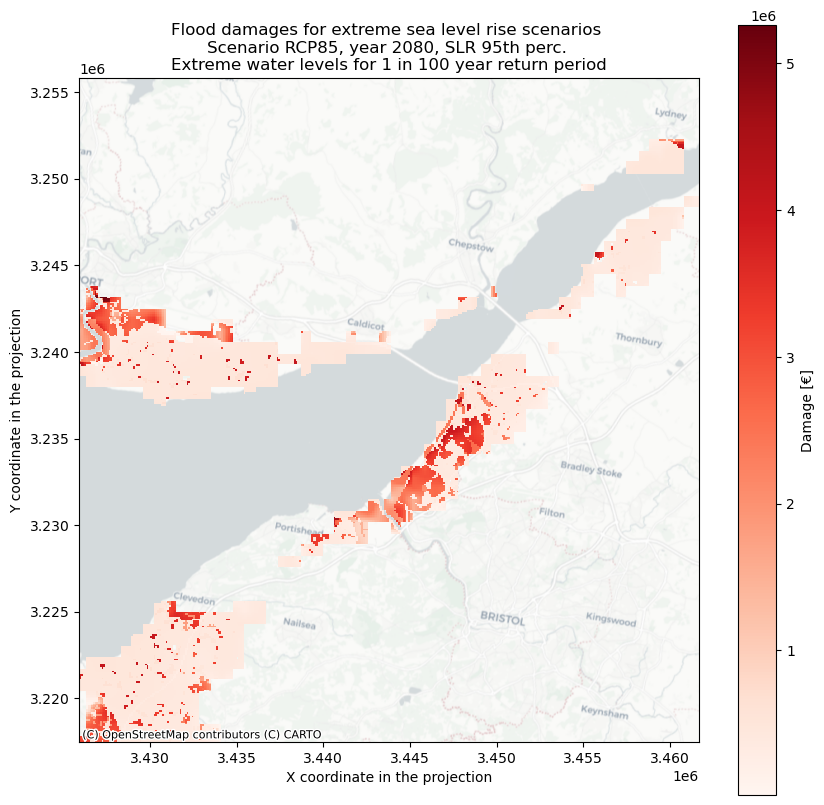

In [119]:
# Open a raster file representing flood damages for a specific scenario
damagemap = rxr.open_rasterio('{}/flood_scenario_{}_{}_Perc{}_{}_rp{:04}_damagemap.tif'.format(results_dir,areaname, scenario, slr_perc,year,rp))

# Select values in the damagemap that are greater than 0
damagemap = damagemap.where(damagemap > 0)

# Create a plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the damagemap with a color map representing damages and a color bar
damagemap.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})

# Set plot title and labels for X and Y coordinates
plt.title('Flood damages for extreme sea level rise scenarios \n' + f'Scenario {scenario.upper()}, year {year}, SLR {slr_perc}th perc. \n' + f'Extreme water levels for 1 in {rp} year return period')
plt.xlabel('X coordinate in the projection')
plt.ylabel('Y coordinate in the projection')

# Add a basemap background to the plot using Contextily
ctx.add_basemap(ax=ax, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

To get a better indication of why certain areas are damaged more than others, we also plot the floodmap and land use maps in one figure.

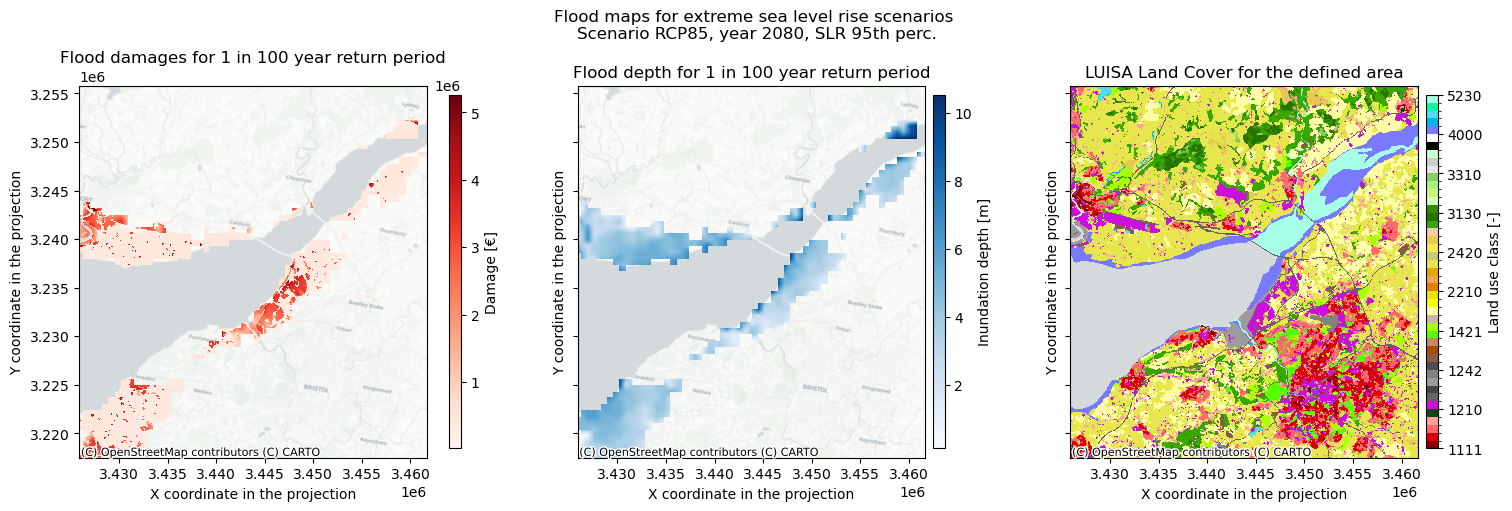

In [120]:
# Create a 2x2 grid of plots with a size of 20x15 inches
fig, ([ax1, ax2, ax3]) = plt.subplots(figsize=(15, 5),nrows=1,ncols=3,sharex=True,sharey=True,layout='constrained')

# Plot flood damages on the first plot
damagemap.plot(ax=ax1, cmap='Reds', cbar_kwargs={'label': "Damage [€]",'pad':0.01,'shrink':0.95,'aspect':30})
ax1.set_title(f'Flood damages for 1 in {rp} year return period')
ax1.set_xlabel('X coordinate in the projection')
ax1.set_ylabel('Y coordinate in the projection')

# Plot inundation depth on the second plot
floodmaps_resampled.sel(year=year,scenario=rcp,slr_percentile=slr_perc,return_period=rp)['inun'].plot(ax=ax2, cmap='Blues', cbar_kwargs={'label': "Inundation depth [m]",'pad':0.01,'shrink':0.95,'aspect':30})
ax2.set_title(f'Flood depth for 1 in {rp} year return period')
ax2.set_xlabel('X coordinate in the projection')
ax2.set_ylabel('Y coordinate in the projection')

# Plot land use on the third plot with custom colors
land_use_small_area.plot(ax=ax3, levels=LUISA_values, colors=LUISA_colors, cbar_kwargs={'label': "Land use class [-]",'pad':0.01,'shrink':0.95,'aspect':30})
ax3.set_title('LUISA Land Cover for the defined area')
ax3.set_xlabel('X coordinate in the projection')
ax3.set_ylabel('Y coordinate in the projection')

plt.suptitle('Flood maps for extreme sea level rise scenarios \n' + f'Scenario {scenario.upper()}, year {year}, SLR {slr_perc}th perc.',fontsize=12)

# Add a map background to each plot using Contextily
ctx.add_basemap(ax1, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, crs=floodmaps_resampled.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax3, crs=land_use_small_area.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Display the plot
plt.show()

fileout = os.path.join(results_dir,'Result_map_{}_{}_Perc{}_{}_rp{:04}.png'.format(areaname, scenario, slr_perc,year,rp))
fig.savefig(fileout) 

Here we see both the the flood depths and the associated damages. What we notice is that high flood depths do not necesarilly corrolate to high damages. Can you see why? It can have two causes. Either the landuse does not have a high economic value, or the land use is very resilient to high water levels. Make sure to check the results and try to explain why high damages do or do not occur in case of high innundation. Find that something is wrong? Reiterate your assumptions made in the **LUISA_damage_info_curves.xlsx** and run the workflow again.

## Conclusions

:::{important}

In this risk workflow we learned:
 - How to get floodmaps and landuse maps for your specific region.
 - Assign each landuse with a vulnerability curve and maxmum damage.
 - Combining the flood (hazard), landuse (exposure), and the vulnerability curves (vulnerability) to obtain an economic damage estimate.
 - Understand where damage comes from and how exposure and vulnerability are an important determinant of risk
:::
